In [86]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as nn_fun
import os
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt

In [87]:
titanic_data = pd.read_csv('../BookCode/pytorch-GNN-1st-main/pytorch-GNN-1st-main/data/05/05/titanic3.csv')
print(titanic_data.columns)

Index(['pclass', 'survived', 'name', 'sex', 'age', 'sibsp', 'parch', 'ticket',
       'fare', 'cabin', 'embarked', 'boat', 'body', 'home.dest'],
      dtype='object')


In [88]:
#用哑变量将指定字段转成one-hot
titanic_data = pd.concat([titanic_data,
                          pd.get_dummies(titanic_data['sex']),
                          pd.get_dummies(titanic_data['embarked'], prefix="embark"),
                          pd.get_dummies(titanic_data['pclass'], prefix="class")], axis=1)

print(titanic_data.columns)

Index(['pclass', 'survived', 'name', 'sex', 'age', 'sibsp', 'parch', 'ticket',
       'fare', 'cabin', 'embarked', 'boat', 'body', 'home.dest', 'female',
       'male', 'embark_C', 'embark_Q', 'embark_S', 'class_1', 'class_2',
       'class_3'],
      dtype='object')


In [89]:
#处理None值
titanic_data["age"] = titanic_data["age"].fillna(titanic_data["age"].mean())
titanic_data["fare"] = titanic_data["fare"].fillna(titanic_data["fare"].mean())  #乘客票价

In [90]:
#删去无用的列
titanic_data = titanic_data.drop(['name', 'ticket', 'cabin', 'boat', 'body', 'home.dest', 'sex', 'embarked', 'pclass'],
                                 axis=1)
print(titanic_data.columns)

Index(['survived', 'age', 'sibsp', 'parch', 'fare', 'female', 'male',
       'embark_C', 'embark_Q', 'embark_S', 'class_1', 'class_2', 'class_3'],
      dtype='object')


In [91]:
titanic_data = titanic_data.astype(np.float_)

In [92]:
#分离样本和标签
labels = titanic_data["survived"].to_numpy()
data = titanic_data.drop(['survived'], axis=1).to_numpy()

data.shape, labels.shape

((1309, 12), (1309,))

In [93]:
#样本的属性名称
feature_names = list(titanic_data.columns)

In [94]:
#将样本分为训练和测试两部分
np.random.seed(10)  #设置种子，保证每次运行所分的样本一致
train_indices = np.random.choice(len(labels), int(0.7 * len(labels)), replace=False)
test_indices = list(set(range(len(labels))) - set(train_indices))
train_features = data[train_indices]
train_labels = labels[train_indices]
test_features = data[test_indices]
test_labels = labels[test_indices]
train_labels.shape, train_features.shape, train_labels.shape, test_features.shape

((916,), (916, 12), (916,), (393, 12))

In [95]:
class Mish(nn.Module):  #Mish激活函数
    def __init__(self):
        super().__init__()
        print("Mish activation loaded...")

    def forward(self, x):
        x = x * (torch.tanh(nn_fun.softplus(x)))
        return x


torch.manual_seed(0)  #设置随机种子


class LinearClassification(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(12, 12), Mish(),
            nn.Linear(12, 8), Mish(),
            nn.Linear(8, 2), nn.Softmax(dim=1)
        )

    def forward(self, x):
        """
        前向传播函数
        :param x: 输入特征矩阵
        :return:
        """
        return self.layers(x)

    def get_loss(self, x, y):
        y_pred = self.forward(x)
        return nn_fun.cross_entropy(y_pred, y.long())

In [96]:
#输出运算资源请况
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [97]:
net = LinearClassification().to(device)

num_epochs = 2000

optimizer = torch.optim.Adam(net.parameters(), lr=0.04)

input_tensor = torch.from_numpy(train_features).type(torch.FloatTensor).to(device)
label_tensor = torch.from_numpy(train_labels).to(device)

losses = []  #定义列表，用于接收每一步的损失值
for epoch in range(num_epochs):
    loss = net.get_loss(input_tensor, label_tensor)
    losses.append(loss.item())
    optimizer.zero_grad()  #清空之前的梯度
    loss.backward()  #反向传播损失值
    optimizer.step()  #更新参数
    if epoch % 20 == 0:
        print('Epoch {}/{} => Loss: {:.2f}'.format(epoch + 1, num_epochs, loss.item()))

os.makedirs('models', exist_ok=True)
torch.save(net.state_dict(), 'models/titanic_model.pt')


def moving_average(a, w=10):  #定义函数计算移动平均损失值
    if len(a) < w:
        return a[:]
    return [val if idx < w else sum(a[(idx - w):idx]) / w for idx, val in enumerate(a)]


def plot_losses(losses):
    avgloss = moving_average(losses)  #获得损失值的移动平均值
    plt.figure(1)
    plt.subplot(211)
    plt.plot(range(len(avgloss)), avgloss, 'b--')
    plt.xlabel('step number')
    plt.ylabel('Training loss')
    plt.title('step number vs. Training loss')
    plt.show()


plot_losses(losses)

Mish activation loaded...
Mish activation loaded...
Epoch 1/500 => Loss: 0.72
Epoch 21/500 => Loss: 0.55
Epoch 41/500 => Loss: 0.52
Epoch 61/500 => Loss: 0.49
Epoch 81/500 => Loss: 0.49
Epoch 101/500 => Loss: 0.48
Epoch 121/500 => Loss: 0.51
Epoch 141/500 => Loss: 0.48
Epoch 161/500 => Loss: 0.48
Epoch 181/500 => Loss: 0.47
Epoch 201/500 => Loss: 0.47
Epoch 221/500 => Loss: 0.49
Epoch 241/500 => Loss: 0.47
Epoch 261/500 => Loss: 0.47
Epoch 281/500 => Loss: 0.47
Epoch 301/500 => Loss: 0.47
Epoch 321/500 => Loss: 0.47
Epoch 341/500 => Loss: 0.47
Epoch 361/500 => Loss: 0.47
Epoch 381/500 => Loss: 0.48
Epoch 401/500 => Loss: 0.47
Epoch 421/500 => Loss: 0.47
Epoch 441/500 => Loss: 0.47
Epoch 461/500 => Loss: 0.47
Epoch 481/500 => Loss: 0.47


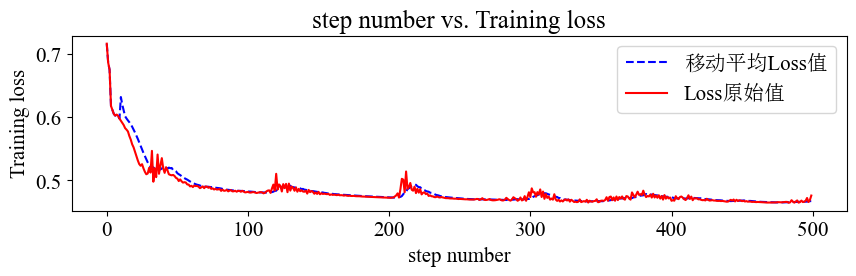

In [98]:
#输出训练结果
out_probs = net(input_tensor).cpu().detach().numpy()
out_classes = np.argmax(out_probs, axis=1)
print("Train Accuracy:", sum(out_classes == train_labels) / len(train_labels))

#测试模型
test_input_tensor = torch.from_numpy(test_features).type(torch.FloatTensor).to(device)  # Numpy转化为Tensor，然后再转移到GPU
out_probs = net(test_input_tensor).cpu().detach().numpy()  # 在GPU完成的运算结果要先转回到CPU才能到Numpy
out_classes = np.argmax(out_probs, axis=1)
print("Test Accuracy:", sum(out_classes == test_labels) / len(test_labels))

Train Accuracy: 0.8449781659388647
Test Accuracy: 0.8040712468193384


In [85]:
out_probs

Train Accuracy: 0.8449781659388647
Test Accuracy: 0.8040712468193384
